In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import statsmodels.formula.api as smf
from datetime import datetime

In [4]:
df = pd.read_csv('mtn_customer_churn.csv')

# Data Overview

*   The 690 missing values in the 'reasons\_for\_churn' column shows active customers.

In [5]:
df.shape

(974, 17)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 974 entries, 0 to 973
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Customer ID                974 non-null    object 
 1   Full Name                  974 non-null    object 
 2   Date of Purchase           974 non-null    object 
 3   Age                        974 non-null    int64  
 4   State                      974 non-null    object 
 5   MTN Device                 974 non-null    object 
 6   Gender                     974 non-null    object 
 7   Satisfaction Rate          974 non-null    int64  
 8   Customer Review            974 non-null    object 
 9   Customer Tenure in months  974 non-null    int64  
 10  Subscription Plan          974 non-null    object 
 11  Unit Price                 974 non-null    int64  
 12  Number of Times Purchased  974 non-null    int64  
 13  Total Revenue              974 non-null    int64  

In [7]:
df.columns

Index(['Customer ID', 'Full Name', 'Date of Purchase', 'Age', 'State',
       'MTN Device', 'Gender', 'Satisfaction Rate', 'Customer Review',
       'Customer Tenure in months', 'Subscription Plan', 'Unit Price',
       'Number of Times Purchased', 'Total Revenue', 'Data Usage',
       'Customer Churn Status', 'Reasons for Churn'],
      dtype='object')

In [8]:
df.columns = df.columns.str.strip().str.lower().str.replace(" ", "_")
df.head()

,customer_id,full_name,date_of_purchase,age,state,mtn_device,gender,satisfaction_rate,customer_review,customer_tenure_in_months,subscription_plan,unit_price,number_of_times_purchased,total_revenue,data_usage,customer_churn_status,reasons_for_churn
0,CUST0001,Ngozi Berry,Jan-25,27,Kwara,4G Router,Male,2,Fair,2,165GB Monthly Plan,35000,19,665000,44.48,Yes,Relocation
1,CUST0002,Zainab Baker,Mar-25,16,Abuja (FCT),Mobile SIM Card,Female,2,Fair,22,12.5GB Monthly Plan,5500,12,66000,19.79,Yes,Better Offers from Competitors
2,CUST0003,Saidu Evans,Mar-25,21,Sokoto,5G Broadband Router,Male,1,Poor,60,150GB FUP Monthly Unlimited,20000,8,160000,9.64,No,NaN
3,CUST0003,Saidu Evans,Mar-25,21,Sokoto,Mobile SIM Card,Male,1,Poor,60,1GB+1.5mins Daily Plan,500,8,4000,197.05,No,NaN
4,CUST0003,Saidu Evans,Mar-25,21,Sokoto,Broadband MiFi,Male,1,Poor,60,30GB Monthly Broadband Plan,9000,15,135000,76.34,No,NaN


In [9]:
# descriptive statistics for numerical columns
df.describe()

,age,satisfaction_rate,customer_tenure_in_months,unit_price,number_of_times_purchased,total_revenue,data_usage
count,974.000000,974.000000,974.000000,974.000000,974.000000,9.740000e+02,974.000000
mean,48.043121,2.947639,31.422998,19196.663244,10.564682,2.046696e+05,99.304764
std,17.764307,1.384219,17.191256,25586.726985,5.709427,3.247855e+05,57.739511
min,16.000000,1.000000,1.000000,350.000000,1.000000,3.500000e+02,0.820000
25%,32.000000,2.000000,17.000000,5500.000000,5.000000,3.300000e+04,47.637500
50%,49.000000,3.000000,31.000000,14500.000000,11.000000,1.080000e+05,103.330000
75%,63.750000,4.000000,47.000000,24000.000000,15.000000,2.610000e+05,149.697500
max,80.000000,5.000000,60.000000,150000.000000,20.000000,3.000000e+06,200.000000


In [10]:
df.isnull().sum()

customer_id                    0
full_name                      0
date_of_purchase               0
age                            0
state                          0
mtn_device                     0
gender                         0
satisfaction_rate              0
customer_review                0
customer_tenure_in_months      0
subscription_plan              0
unit_price                     0
number_of_times_purchased      0
total_revenue                  0
data_usage                     0
customer_churn_status          0
reasons_for_churn            690
dtype: int64

In [11]:
print("There's 690 missing values for reason of churn")

There's 690 missing values for reason of churn


In [12]:
df.duplicated().sum()

0

In [13]:
# dropping the customer_id since full_name can serve the same need
df.drop("customer_id", axis=1, inplace=True)

## Exploratory Data Analysis (EDA)

To explore the data and find relevant business insights.

# Discovering Business insights

In [14]:
#to group the DataFrame by the 'mtn_device' column
product_type = df.groupby("mtn_device")
churn_status = df["customer_churn_status"]

In [15]:
#keys of the grouped object, which represent the unique MTN device types
pd.DataFrame(product_type.groups.keys())

,0
0,4G Router
1,5G Broadband Router
2,Broadband MiFi
3,Mobile SIM Card


                     count    min      max        sum
mtn_device                                           
5G Broadband Router    229  18000  3000000  100818000
Broadband MiFi         228   9000   600000   48067500
4G Router              216   4500   700000   37028000
Mobile SIM Card        301    350   595000   13434700


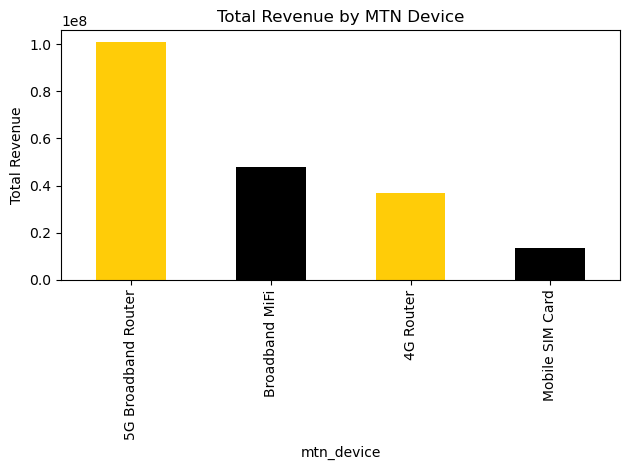

In [16]:
# To return the first row of each group
#product_type.first()
#And Summarizing and finding out the total sum of revenue generated from each product type
product_summary = product_type["total_revenue"].agg(['count','min', 'max', 'sum']).sort_values(by='sum', ascending=False)
print(product_summary)
product_summary['sum'].plot(kind='bar', ylabel='Total Revenue', title= 'Total Revenue by MTN Device',color=["#FFCC08","black"])
plt.tight_layout()
plt.show()

customer_churn_status
No     690
Yes    284
Name: count, dtype: int64


<Axes: title={'center': 'Churned Vs Non-churned Customer'}, xlabel='customer_churn_status', ylabel='Count'>

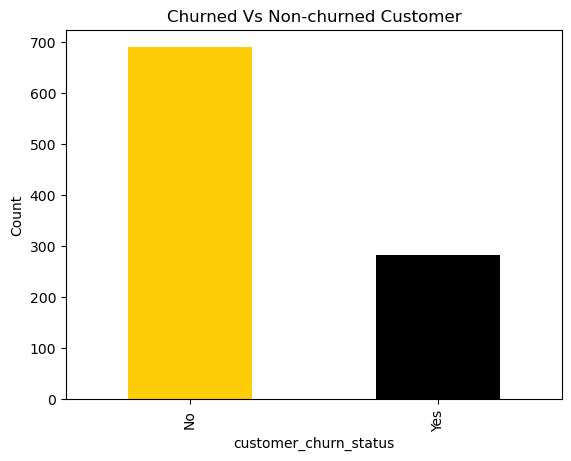

In [17]:
#to show the count of each customer churn status (Yes/No)
print(churn_status.value_counts())
# a bar chart showing the count of churned and non-churned customers
churn_status.value_counts().plot(kind='bar', title='Churned Vs Non-churned Customer', ylabel="Count",color=["#FFCC08","black"])

subscription_plan
60GB Monthly Broadband Plan     81
150GB FUP Monthly Unlimited     78
30GB Monthly Broadband Plan     77
165GB Monthly Plan              73
300GB FUP Monthly Unlimited     72
120GB Monthly Broadband Plan    68
10GB+10mins Monthly Plan        67
65GB Monthly Plan               63
25GB Monthly Plan               49
12.5GB Monthly Plan             38
3.2GB 2-Day Plan                35
200GB Monthly Broadband Plan    31
2.5GB 2-Day Plan                30
16.5GB+10mins Monthly Plan      30
500MB Daily Plan                29
1.5GB 2-Day Plan                29
7GB Monthly Plan                27
1.5TB Yearly Broadband Plan     25
450GB 3-Month Broadband Plan    25
1GB+1.5mins Daily Plan          24
20GB Monthly Plan               23
Name: count, dtype: int64


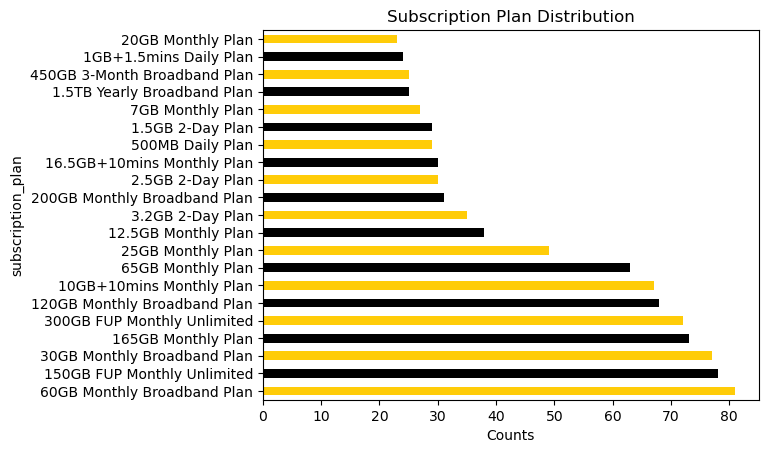

In [18]:
# the value counts of each subscription plan
print(df['subscription_plan'].value_counts())
# a horizontal bar chart showing the count of each subscription plan
df['subscription_plan'].value_counts().plot(kind="barh",title=('Subscription Plan Distribution'),xlabel="Counts",color=["#FFCC08","black"])
plt.show()

In [19]:
# the total sum of the 'total_revenue' column
print(f"Total Amount of Money generated is : N{df['total_revenue'].sum()}M")

Total Amount of Money generated is : N199348200M


In [20]:
# Converting the 'date_of_purchase' column to datetime objects
df['date_of_purchase']=pd.to_datetime(df['date_of_purchase'], format='%b-%y')

In [21]:
#changing datetime to it prospective month name
df["month_of_purchase"] = df["date_of_purchase"].dt.month_name()

<Axes: title={'center': 'Trend on subscription between the months'}, xlabel='date_of_purchase'>

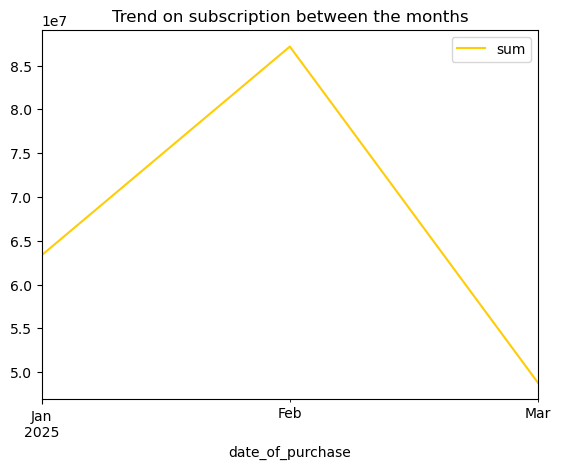

In [22]:
# Grouping the DataFrame by 'date_of_purchase' and calculate the count and sum of 'total_revenue' for each month
monthly_trend = df.groupby('date_of_purchase')['total_revenue'].agg(['count', 'sum'])
# a line chart showing the total revenue trend over the months
monthly_trend['sum'].plot(kind='line', color="#FFCC08",legend=True , title='Trend on subscription between the months')

In [23]:
# grouping the DataFrame by 'full_name' and 'number_of_times_purchased' and calculate the sum of 'total_revenue' by each custom
cust_summary = df.groupby(['full_name','number_of_times_purchased'])['total_revenue'].agg('sum')
top_customer = cust_summary.sort_values(ascending=False)
top_customer.head(5)

full_name      number_of_times_purchased
Alabo Turner   20                           3000000
Halima Martin  20                           3000000
Kunle Myers    19                           2850000
Chinedu Brown  19                           2850000
Amina Johns    16                           2400000
Name: total_revenue, dtype: int64

state
Plateau    9463600
Ekiti      9240250
Yobe       8881700
Oyo        8600350
Edo        7937650
Name: total_revenue, dtype: int64


<Axes: ylabel='state'>

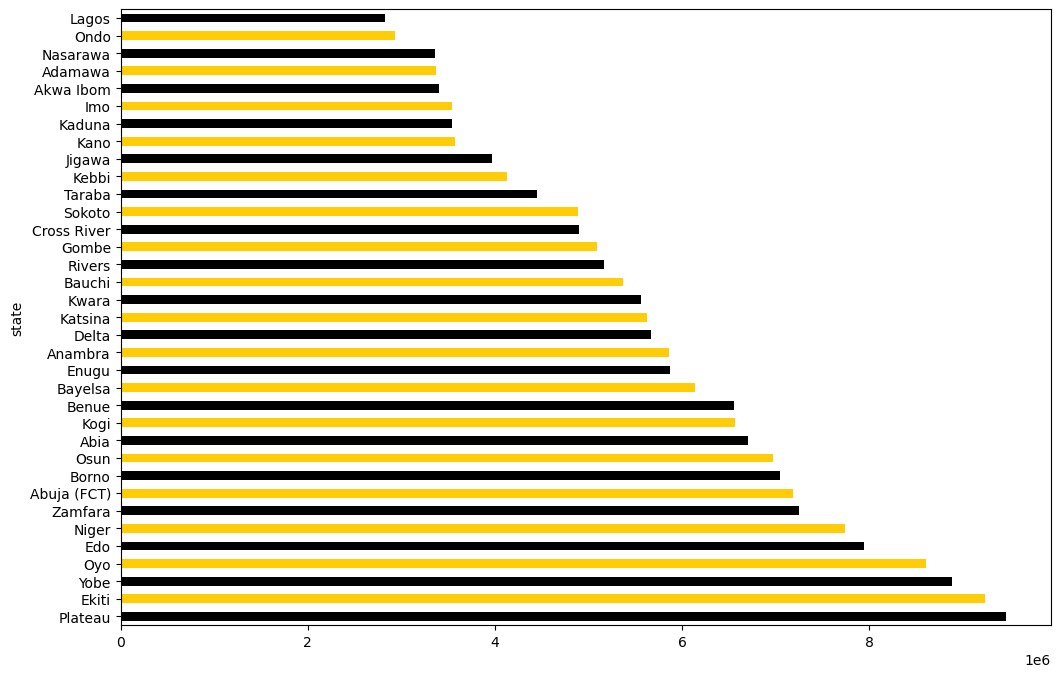

In [24]:
# group the DataFrame by 'state' and calculate the sum of 'total_revenue'
rev_by_state = df.groupby("state")["total_revenue"].agg("sum").sort_values(ascending=False)
print(rev_by_state.head())
# a horizontal bar chart showing the total revenue by state
rev_by_state.plot(kind="barh", figsize=(12,8), color=['black', '#FFCC08'])

gender
Female    495
Male      479
Name: total_revenue, dtype: int64


<Axes: title={'center': 'Revenue by gender: female vs male'}, xlabel='gender'>

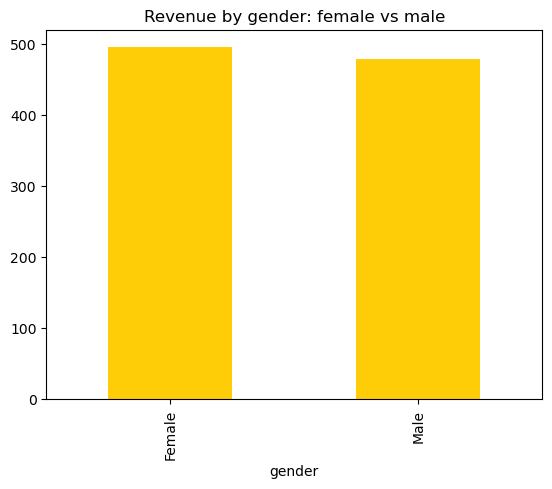

In [25]:
# grouping the DataFrame by 'gender' and count the occurrences of each gender in 'total_revenue'
rev_by_gender = df.groupby("gender")["total_revenue"].count()
print(rev_by_gender)
# a bar chart showing the revenue count by gender
rev_by_gender.plot(kind="bar",color="#FFCC08", title="Revenue by gender: female vs male")

gender                        Female  Male
subscription_plan                         
1.5GB 2-Day Plan                  20     9
1.5TB Yearly Broadband Plan       14    11
10GB+10mins Monthly Plan          43    24
12.5GB Monthly Plan               23    15
120GB Monthly Broadband Plan      41    27
150GB FUP Monthly Unlimited       38    40
16.5GB+10mins Monthly Plan        17    13
165GB Monthly Plan                37    36
1GB+1.5mins Daily Plan             9    15
2.5GB 2-Day Plan                  14    16
200GB Monthly Broadband Plan      16    15
20GB Monthly Plan                 11    12
25GB Monthly Plan                 22    27
3.2GB 2-Day Plan                  15    20
300GB FUP Monthly Unlimited       38    34
30GB Monthly Broadband Plan       35    42
450GB 3-Month Broadband Plan      12    13
500MB Daily Plan                  11    18
60GB Monthly Broadband Plan       41    40
65GB Monthly Plan                 28    35
7GB Monthly Plan                  10    17


<Figure size 1200x1000 with 0 Axes>

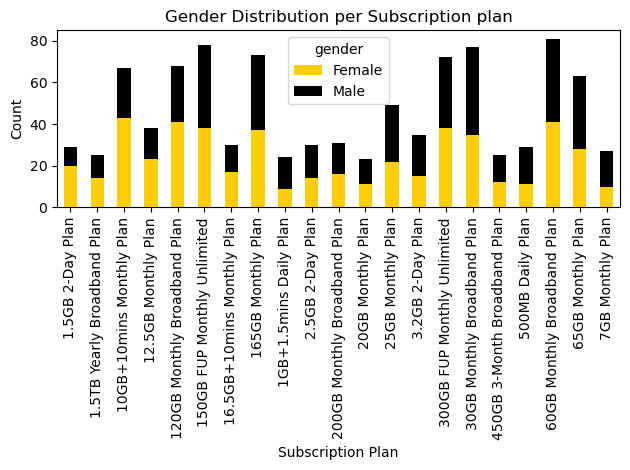

In [26]:
# grouping the DataFrame by 'subscription_plan' and 'gender'
sub_plan_gender = df.groupby('subscription_plan')['gender'].value_counts().unstack(fill_value =0)
# showing gender distribution per subscription plan
print(sub_plan_gender)
plt.figure(figsize=(12, 10))
sub_plan_gender.plot(kind='bar',color=["#FFCC08","black"],stacked=True)
plt.xticks(rotation=90)
plt.xlabel('Subscription Plan')
plt.ylabel('Count')
plt.title("Gender Distribution per Subscription plan")
plt.tight_layout()
plt.show()

In [27]:
# Calculating the average amount of subscription plans
avg_amount = sum(df.unit_price)/len(df.unit_price)
print(f"The average amount of subscription by the customers is: N{avg_amount}")
below_avg=sum(1 for x in df.unit_price if x < avg_amount)
# a Count of the number of customers subscribing above the average amount
above_avg=sum(1 for x in df.unit_price if x > avg_amount)
print(f"The total number of customers subscribing below the average amount is:{below_avg}\n And above the average amount is: {above_avg}")

The average amount of subscription by the customers is: N19196.66324435318
The total number of customers subscribing below the average amount is:602
 And above the average amount is: 372


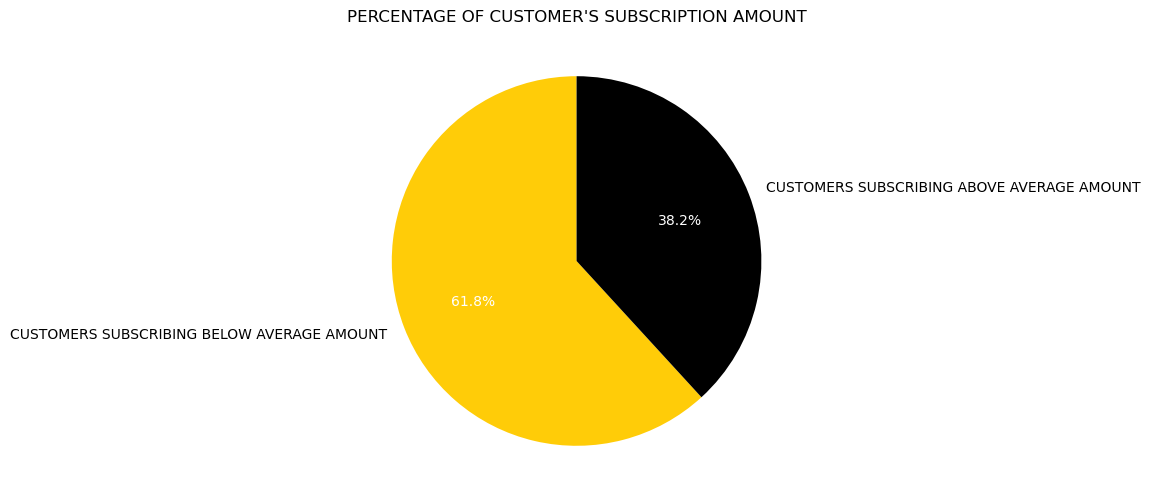

In [28]:
# a pie chart to show customers below and above average subscription amount
values=[below_avg, above_avg]
plt.figure(figsize=(12,6))
patches, texts, autotexts = plt.pie(values,colors=["#FFCC08","black"],labels=["CUSTOMERS SUBSCRIBING BELOW AVERAGE AMOUNT", "CUSTOMERS SUBSCRIBING ABOVE AVERAGE AMOUNT"], startangle=90, autopct='%.1f%%')
plt.title("PERCENTAGE OF CUSTOMER'S SUBSCRIPTION AMOUNT")
for autotext in autotexts:
    autotext.set_color('white')
plt.show()

# Detailed Exploratory Data Analysis (EDA)

### *Categorical Variables and Churn Status*

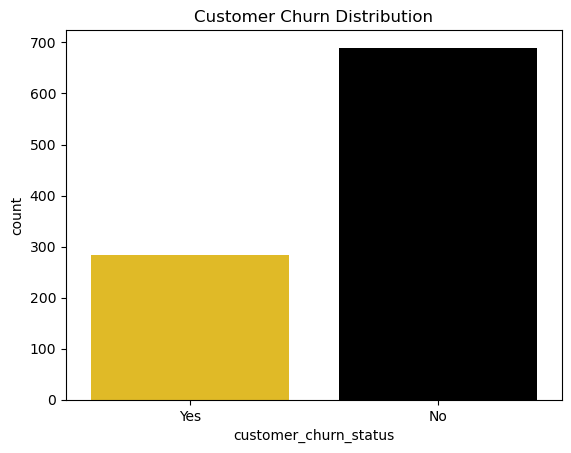

In [29]:
sns.countplot(x="customer_churn_status",data=df, hue="customer_churn_status", palette=["#FFCC08","black"], legend=False)
plt.title("Customer Churn Distribution")
plt.show()

In [30]:
categorical_cols = df.select_dtypes(object).drop(['full_name','customer_churn_status'],axis=1)
categorical_cols.tail()

,state,mtn_device,gender,customer_review,subscription_plan,reasons_for_churn,month_of_purchase
969,Osun,4G Router,Female,Good,25GB Monthly Plan,NaN,January
970,Bayelsa,5G Broadband Router,Female,Fair,30GB Monthly Broadband Plan,NaN,March
971,Kebbi,4G Router,Male,Very Good,165GB Monthly Plan,High Call Tarriffs,February
972,Kebbi,Mobile SIM Card,Male,Very Good,7GB Monthly Plan,High Call Tarriffs,February
973,Kebbi,Broadband MiFi,Male,Very Good,150GB FUP Monthly Unlimited,High Call Tarriffs,February


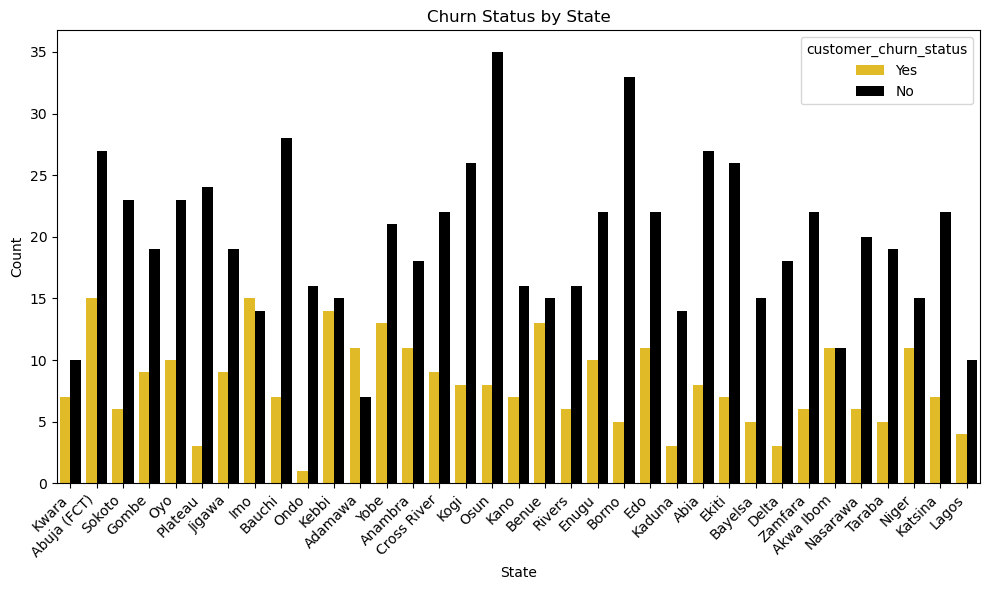

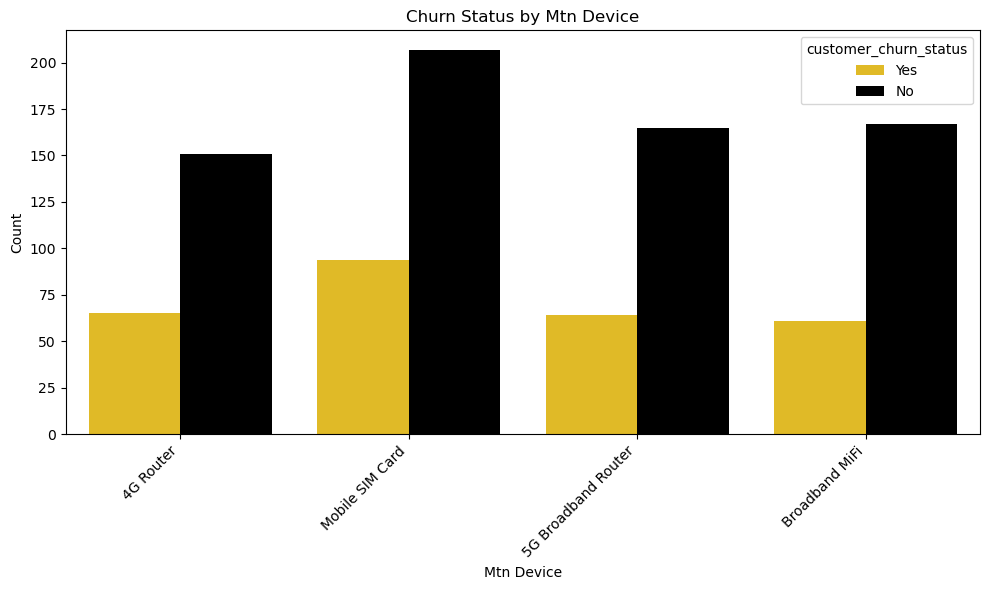

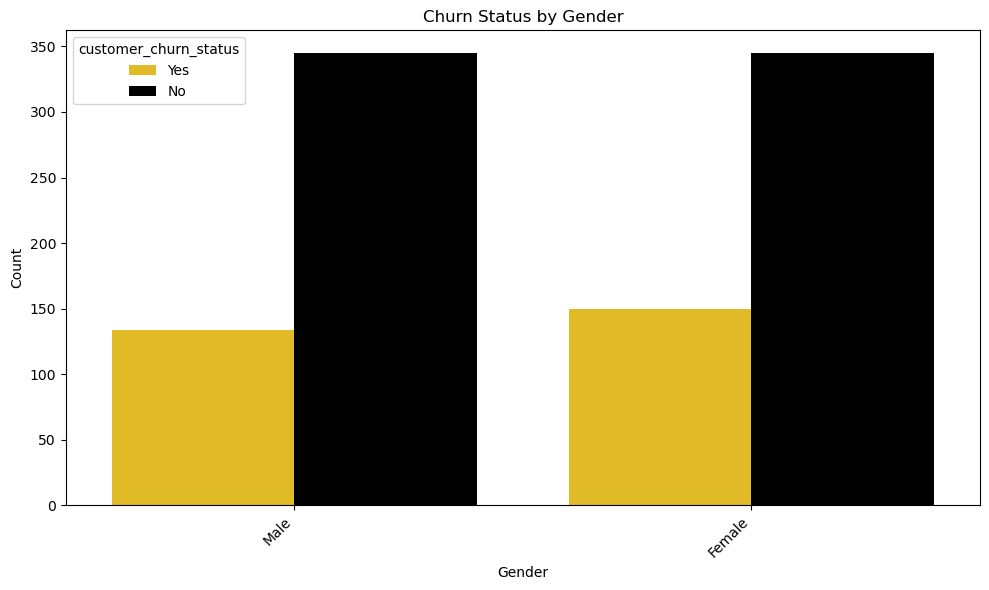

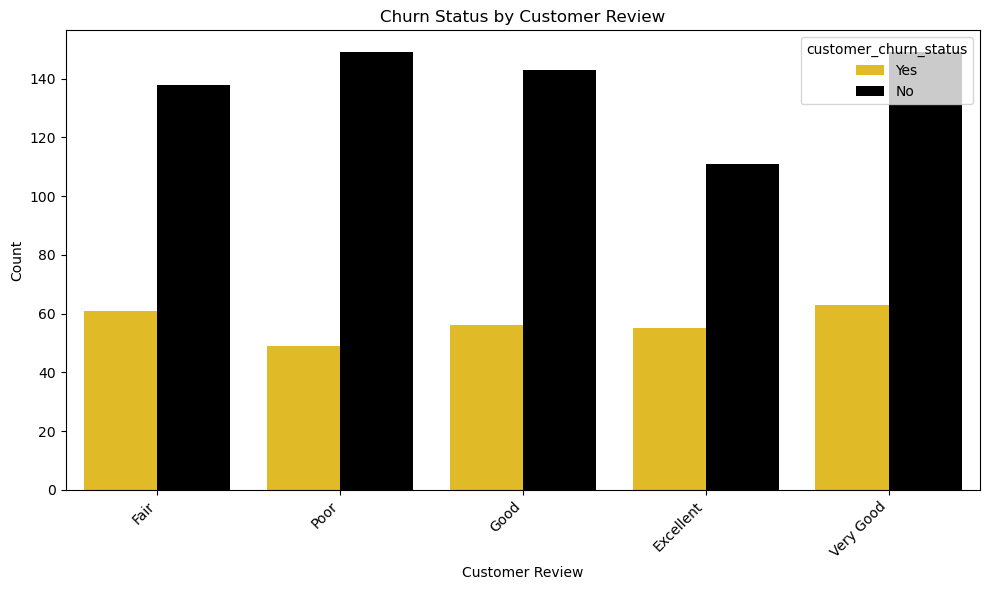

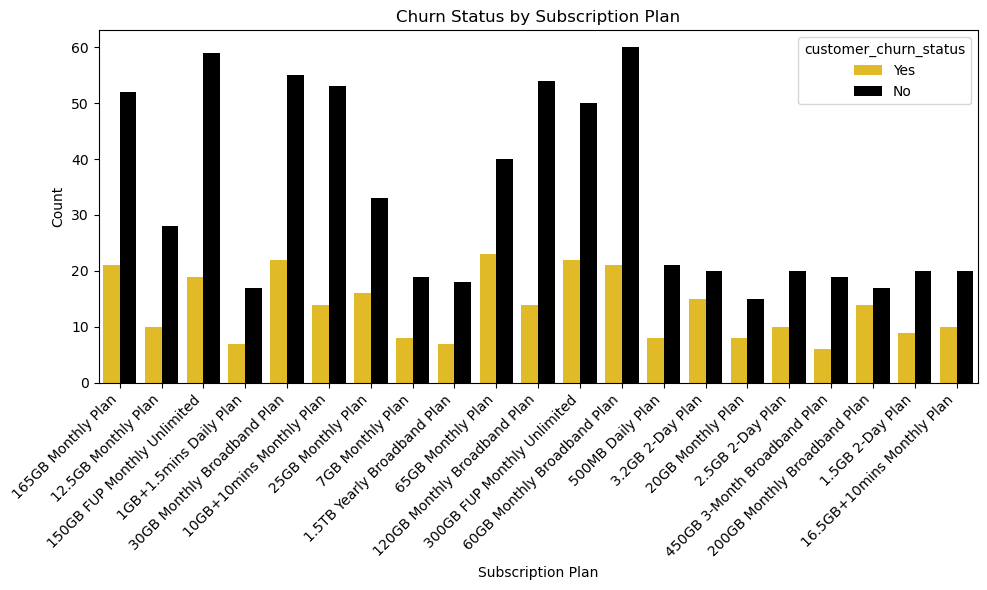

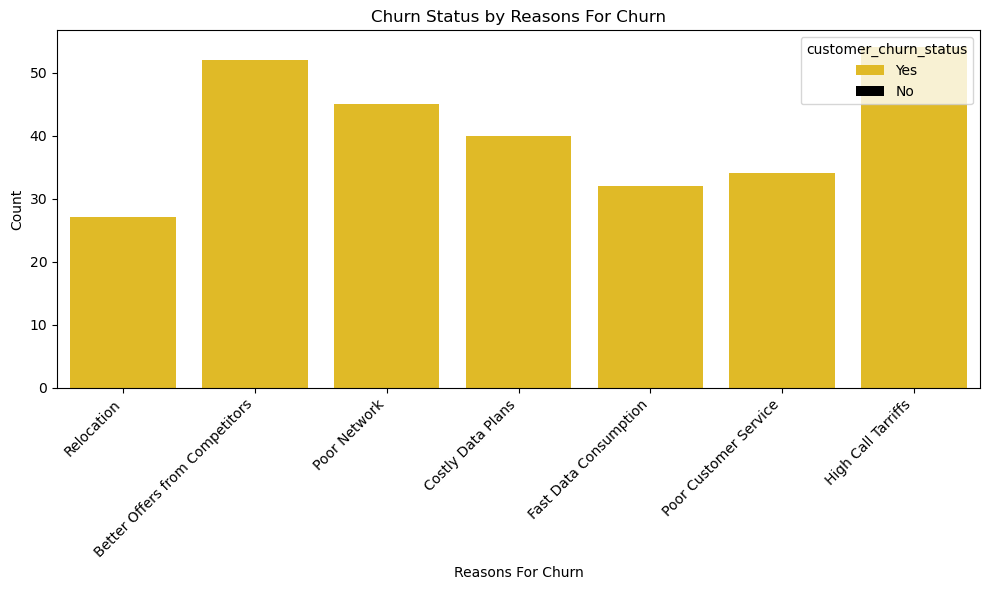

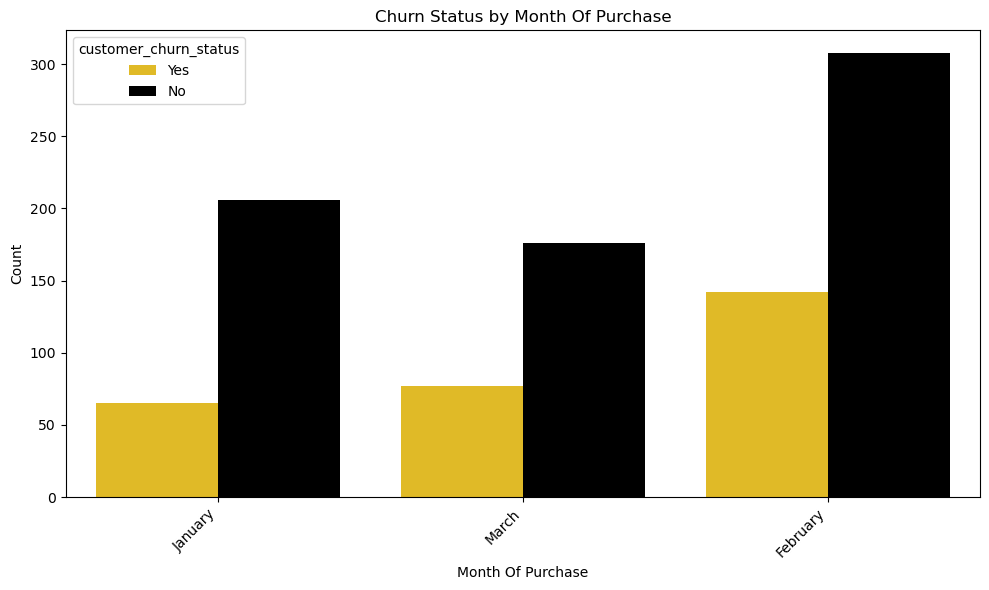

In [31]:
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=col, hue='customer_churn_status', palette=["#FFCC08", "black"])
    plt.title(f'Churn Status by {col.replace("_", " ").title()}')
    plt.xlabel(col.replace("_", " ").title())
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

reasons_for_churn
High Call Tarriffs                54
Better Offers from Competitors    52
Poor Network                      45
Costly Data Plans                 40
Poor Customer Service             34
Fast Data Consumption             32
Relocation                        27
Name: count, dtype: int64


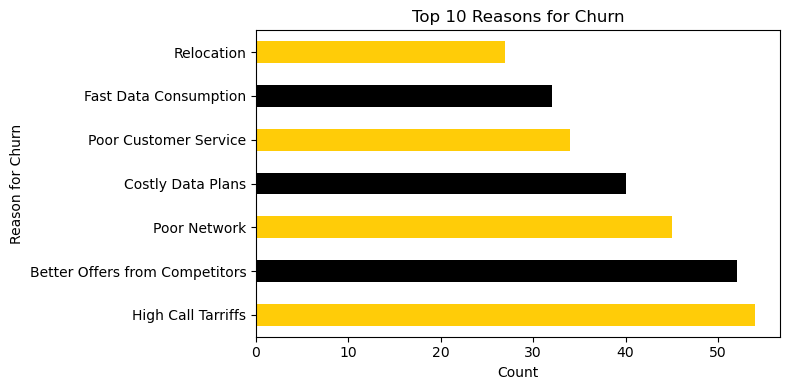

In [32]:
# value counts of the 'reasons_for_churn' column
print(df['reasons_for_churn'].value_counts())
# a bar chart of the top 10 reasons for churn
df['reasons_for_churn'].value_counts().head(10).plot(kind='barh', title='Top 10 Reasons for Churn', xlabel='Count', ylabel='Reason for Churn', color=["#FFCC08","black"],figsize=(8,4))
plt.tight_layout()
plt.show()

### Numerical Variables and Churn Status

In [33]:
# Map 'Yes' to 1 and 'No' to 0 in the 'customer_churn_status' column and creating a new column 'churn_flag'
df['churn_flag'] = df["customer_churn_status"].map({'Yes': 1, 'No': 0})

In [34]:
numerical_cols = df.select_dtypes(np.number)
sub_num_col=df[['satisfaction_rate','unit_price','number_of_times_purchased']]

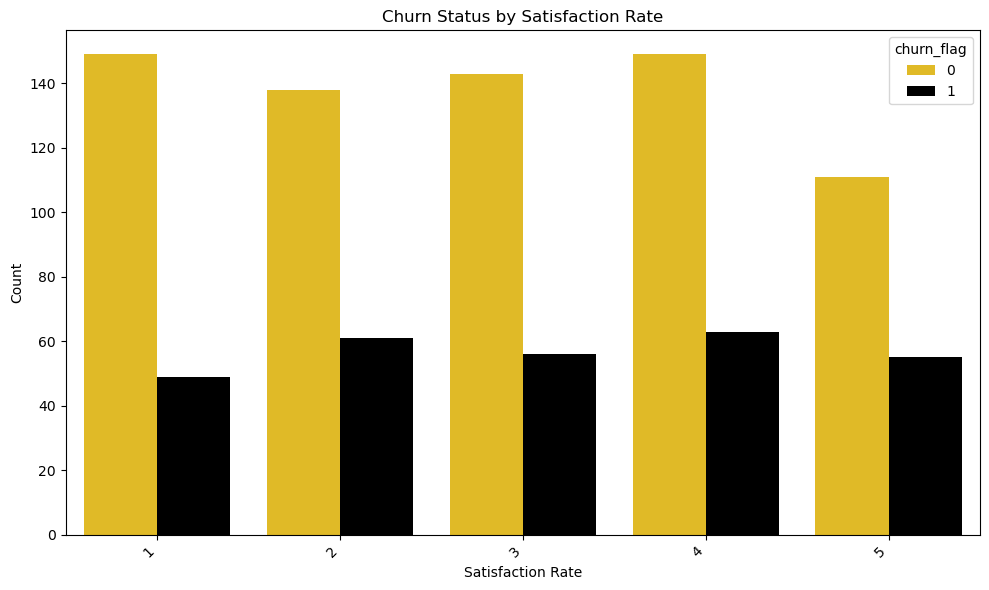

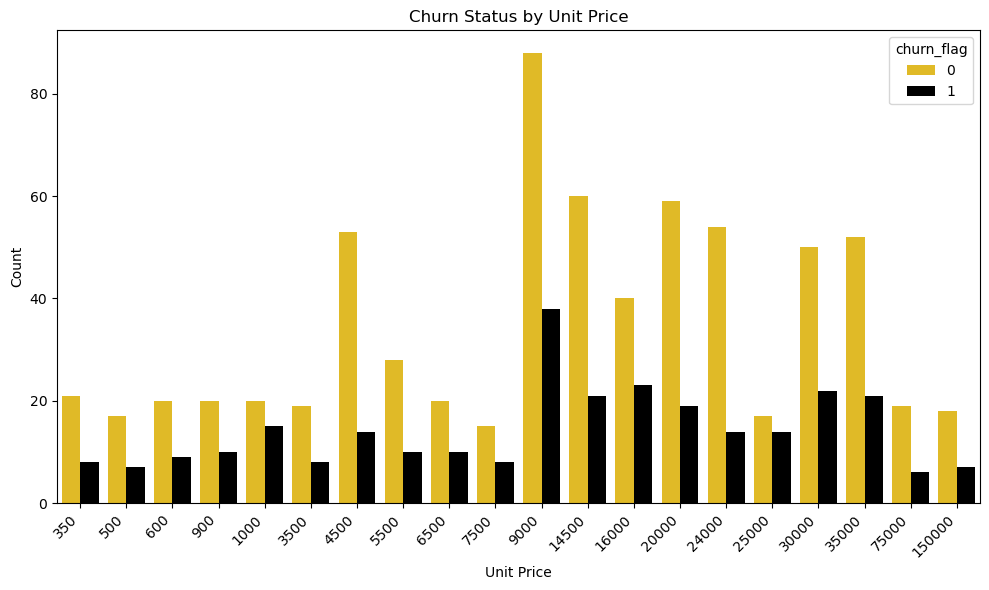

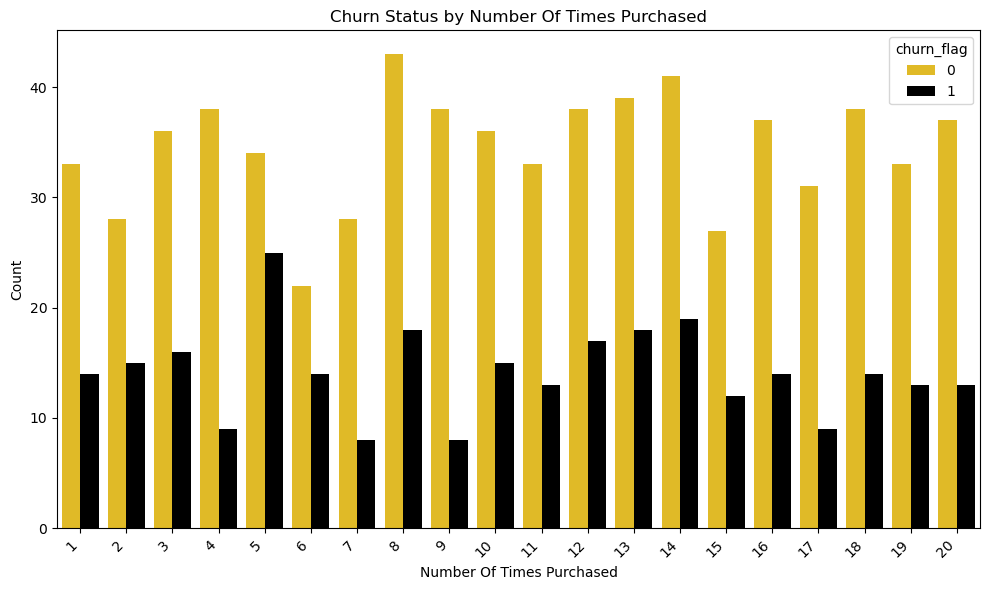

In [35]:
for col in sub_num_col:
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=col, hue='churn_flag', palette=["#FFCC08", "black"])
    plt.title(f'Churn Status by {col.replace("_", " ").title()}')
    plt.xlabel(col.replace("_", " ").title())
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

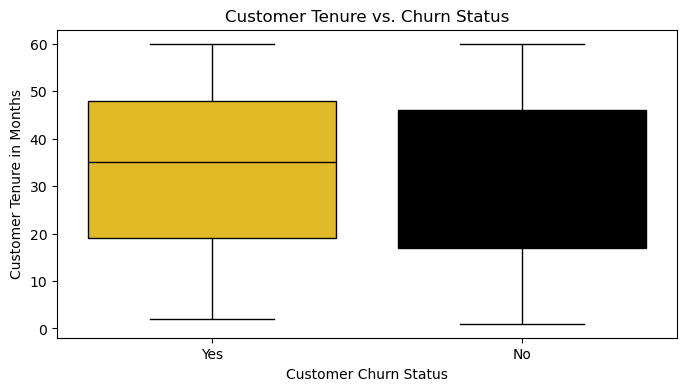

In [36]:
plt.figure(figsize=(8, 4))
# to create a box plot to visualize the distribution of customer tenure for churned and non-churned customers
sns.boxplot(data=df, x='customer_churn_status', y='customer_tenure_in_months', hue='customer_churn_status', palette=["#FFCC08", "black"], legend=False)
plt.title('Customer Tenure vs. Churn Status')
plt.xlabel('Customer Churn Status')
plt.ylabel('Customer Tenure in Months')
plt.show()

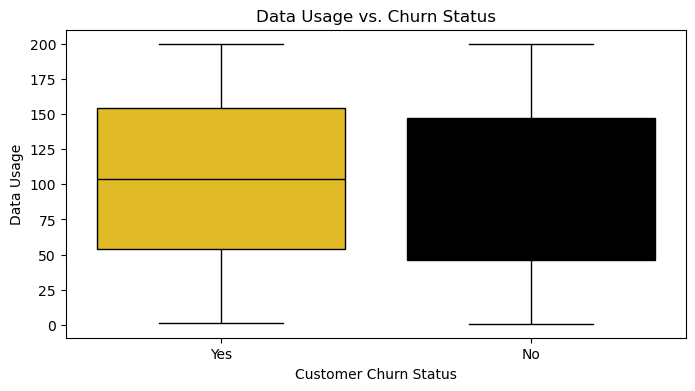

In [37]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=df, x='customer_churn_status', y='data_usage', hue='customer_churn_status', palette=["#FFCC08", "black"], legend=False)
plt.title('Data Usage vs. Churn Status')
plt.xlabel('Customer Churn Status')
plt.ylabel('Data Usage')
plt.show()

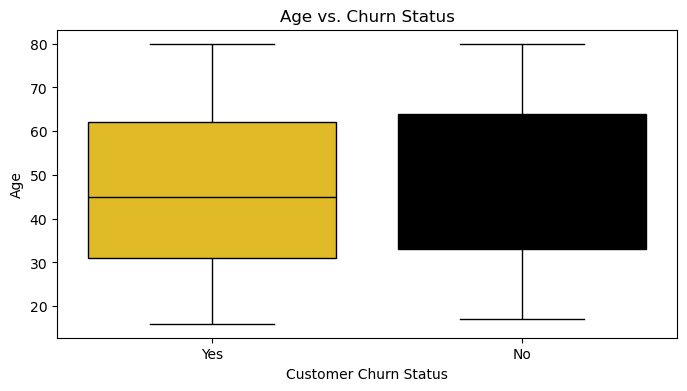

In [38]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=df, x='customer_churn_status', y='age', hue='customer_churn_status', palette=["#FFCC08", "black"], legend=False)
plt.title('Age vs. Churn Status')
plt.xlabel('Customer Churn Status')
plt.ylabel('Age')
plt.show()

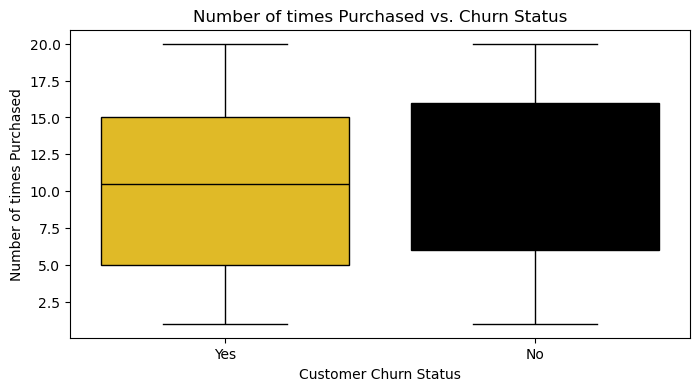

In [39]:
plt.figure(figsize=(8, 4))
sns.boxplot(data=df, x='customer_churn_status', y='number_of_times_purchased', hue='customer_churn_status', palette=["#FFCC08", "black"], legend=False)
plt.title('Number of times Purchased vs. Churn Status')
plt.xlabel('Customer Churn Status')
plt.ylabel('Number of times Purchased')
plt.show()